In [ ]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 411s 4s/step - accuracy: 0.6017 - loss: 1.1028 - val_accuracy: 0.7258 - val_loss: 0.7625
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 438s 4s/step - accuracy: 0.7093 - loss: 0.7978 - val_accuracy: 0.7299 - val_loss: 0.7346
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 442s 4s/step - accuracy: 0.7168 - loss: 0.7742 - val_accuracy: 0.7149 - val_loss: 0.7395
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 436s 4s/step - accuracy: 0.7099 - loss: 0.7709 - val_accuracy: 0.7353 - val_loss: 0.6970
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 441s 4s/step - accuracy: 0.7256 - loss: 0.7504 - val_accuracy: 0.7503 - val_loss: 0.7056
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 393s 4s/step - accuracy: 0.7441 - loss: 0.7068 - val_accuracy: 0.7476 - val_loss: 0.6996
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 459s 4s/step - accuracy: 0.7578 - loss: 0.6787 - val_accuracy: 0.7531 - val_loss: 0.6790
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 409s 4s/step - accuracy: 0.7650 - loss: 0.6678 - val_accuracy: 0.7435 - v

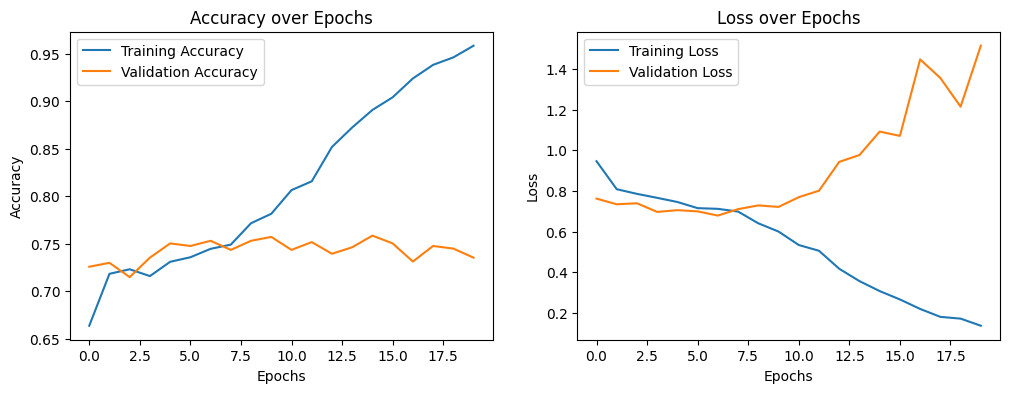

In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Step 1: Load the CSV file
csv_file_path = '/content/drive/MyDrive/train.csv'
df = pd.read_csv(csv_file_path)

# Step 2: Define image paths and labels
image_dir = {
    '0': '/content/drive/MyDrive/colored_images/No_DR',
    '1': '/content/drive/MyDrive/colored_images/Mild',
    '2': '/content/drive/MyDrive/colored_images/Moderate' ,
    '3': '/content/drive/MyDrive/colored_images/Severe',
    '4': '/content/drive/MyDrive/colored_images/Proliferate_DR'
}
image_paths = []
labels = []

# Assuming the CSV has 'filename' and 'label' columns
for idx, row in df.iterrows():
    filename = row['id_code']
    label = row['diagnosis']
    # Add .png extension to filename
    # Make sure the filenames in your CSV match the actual filenames in your folders, including the extension.
    image_path = os.path.join(image_dir[str(label)], filename + ".png")

    # Check if the image file actually exists
    if os.path.exists(image_path):
        image_paths.append(image_path)
        labels.append(label)
    else:
        print(f"Warning: Image file not found: {image_path}")

# Step 3: Preprocess the images
def preprocess_images(image_paths, target_size=(224, 224)):
    images = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=target_size)
        img = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img)
    return np.array(images)

# Convert images to numpy arrays
X = preprocess_images(image_paths)

# Convert labels to a numpy array and one-hot encode them
y = np.array(labels)
y = to_categorical(y, num_classes=5)  # 5 classes: 0 to 4

# Step 4: Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

# Step 5: Create the CNN model
def create_cnn_model(input_shape=(224, 224, 3)):
    model = Sequential()

    # 1st convolutional block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 2nd convolutional block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3rd convolutional block
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and fully connected layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))  # 5 classes (0-4)

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Initialize and train the model
model = create_cnn_model()

# Step 6: Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Step 7: Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

# Step 8: Plot training history (optional)
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

# Save the model
model.save('diabetic_retinopathy_model.h5')

23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step


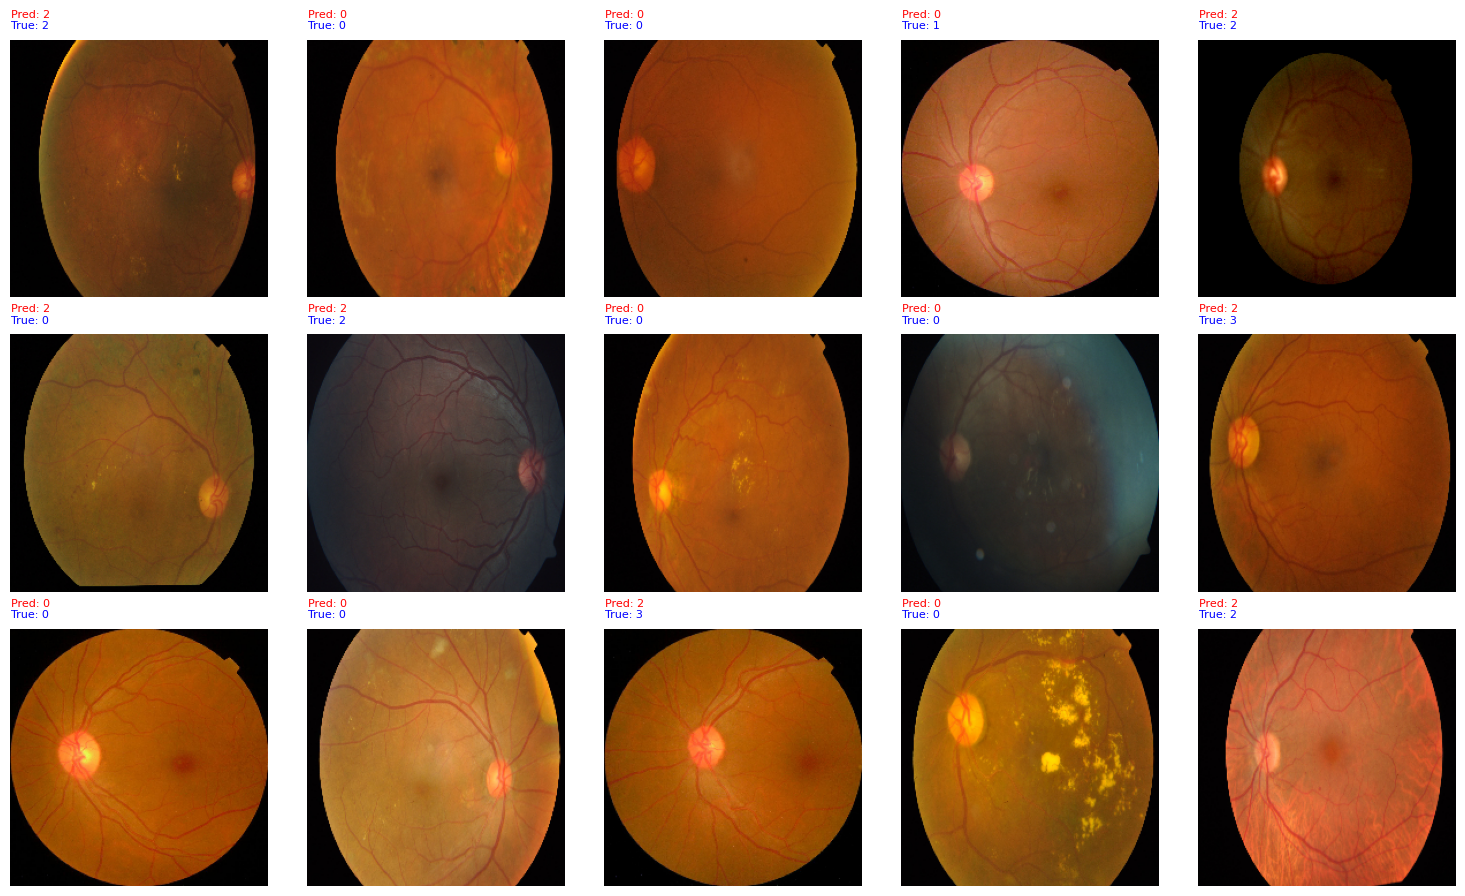

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get predictions for the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Create a figure and axes for the grid
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

# Iterate through the first 15 images in the validation set
for i in range(15):
    row = i // 5
    col = i % 5
    image_path = image_paths[i]  # Assuming image_paths corresponds to X_val

    # Load and display the image
    img = load_img(image_path, target_size=(224, 224))
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

    # Get true and predicted labels
    true_label = y_true_classes[i]
    predicted_label = y_pred_classes[i]

    # Add the labels as text to the subplot
    axes[row, col].text(0, -10, f"True: {true_label}", fontsize=8, color='blue')
    axes[row, col].text(0, -20, f"Pred: {predicted_label}", fontsize=8, color='red')

plt.tight_layout()
plt.show()